<img src="https://raw.githubusercontent.com/dask/dask/main/docs/source/images/dask_horizontal.svg"
     width="60%"
     alt="Dask logo\" />

# Process Tabular Data with Dask DataFrame
In this notebook we will learn about the [Dask DataFrame](https://docs.dask.org/en/latest/dataframe.html), a tabular DataFrame interface based on pandas that will automatically build parallel computations.

## When to use Dask DataFrames

Pandas is great for tabular datasets that fit in memory. If your data fits in memory then you should use Pandas. **Dask becomes useful when the dataset you want to analyze is larger than your machine's RAM** where you would normally run into `MemoryError`s.

```python
    MemoryError:  ...
```

This also means:

## Don't use Dask DataFrames if you don't need to!
Distributed computing brings a lot of additional complexity into the mix and will **incur overhead**. If your dataset and computations fit comfortably within your local resources **this overhead will may be larger than the performance gain** you'll get by using Dask. In that case, stick with non-distributed libraries like pandas, numpy and scikit-learn. 

## About this notebook
During this tutorial, we will work with a dataset containg NYC flight data. This dataset is only about 200MB on disk so that you can download it in a reasonable time and exercises finish quickly, but Dask Dataframes will scale to datasets much larger than the memory on your local machine. 

## Getting started with Dask DataFrames

Let's use Dask DataFrame's to explore the NYC flight dataset. Dask's `read_csv` function supports wildcard characters like `"*"` which can be used to load an entire directory of CSV files.

In [32]:
%run ../prep_data.py -d flights

data_dir='/Users/rpelgrim/Documents/git/intro-to-dask/data'


In [33]:
import os

files = os.path.join('../data', 'nycflights', '*.csv')
files

'../data/nycflights/*.csv'

In [34]:
import dask.dataframe as dd

In [35]:
ddf = dd.read_csv(files,
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={"TailNum": str,
                        "CRSElapsedTime": float,
                        "Cancelled": bool})
ddf

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Notice that the representation of the dataframe object contains no data - Dask has just done enough to read the start of the first file, and infer the column names and dtypes.

**Dask is lazy!**

In [36]:
ddf.columns

Index(['Date', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted'],
      dtype='object')

In [37]:
ddf.dtypes

Date                 datetime64[ns]
DayOfWeek                     int64
DepTime                     float64
CRSDepTime                    int64
ArrTime                     float64
CRSArrTime                    int64
UniqueCarrier                object
FlightNum                     int64
TailNum                      object
ActualElapsedTime           float64
CRSElapsedTime              float64
AirTime                     float64
ArrDelay                    float64
DepDelay                    float64
Origin                       object
Dest                         object
Distance                    float64
TaxiIn                      float64
TaxiOut                     float64
Cancelled                      bool
Diverted                      int64
dtype: object

Dask DataFrames have an `.npartitions` attribute which tells you how many partitions make up a Dask DataFrame.

Dask is able to process larger-than-memory datasets by cutting computations into smaller parts and processing those in parallel.

In [38]:
ddf.npartitions

10

## The pandas Look & Feel
Dask DataFrames implement a well-used portion of the Pandas API in a way that allows for parallel and out-of-core computation. This means that a lot of Dask DataFrame code will look and feel familiar to pandas users: 

```python
import pandas as pd                   import dask.dataframe as dd
df = pd.read_csv('2015-01-01.csv')    df = dd.read_csv('2015-*-*.csv')
df.groupby(df.user_id).value.mean()   df.groupby(df.user_id).value.mean().compute()
```

This is because, internally, **a Dask DataFrame is composed of many pandas DataFrames**: 

<img src="http://dask.pydata.org/en/latest/_images/dask-dataframe.svg" width="50%">

Dask DataFrames are divided into different **partitions** where each partition is a pandas DataFrame. This is why driving the Dask car *can feel* like you're still driving the pandas car: Dask is performing a bunch of regular pandas operations on regular pandas objects under the hood.

But don't forget that you've entered the world of distributed computing now -- which means you've added a lot more complexity to the mix. You now need to consider things like concurrency, state, data duplicates, data loss, etc.

Luckily, with a high-level Collection like DataFrames, Dask handles most of these complicated questions for you. 

## pandas-like Computations

Let's see this in action with a more involved example. Let's compute the largest flight departure delay.

In pandas we could do this by iterating over each file to find the individual maximums and then find the final maximum over the individual maximums.

```python
maxes = []
for fn in filenames:
    df = pd.read_csv(fn)
    maxes.append(df["DepDelay"].max())

final_max = max(maxes)
```

Thankfully, we can do this with Dask DataFrames using pandas-like code:

In [39]:
max_delay = ddf["DepDelay"].max()

In [40]:
max_delay

dd.Scalar<series-..., dtype=float64>

The above cell looks exactly like what we would do using pandas...but the result does not! 

Instead of the actual result of the computation, we only get some schematic information. This is because Dask DataFrames are lazily evaluated. This means that **no computation happens unless you explicitly tell Dask to do so** by calling `.compute()`.

Before actually performing a computation, dask first constructs a task graph that it can use to optimize computing the result in parallel. You can think of a task graph as the recipe or routemap that contains all the necessary instructions to arrive at the final result. Once you call `.compute()`, Dask will execute the instructions contained in the task graph and perform computations in parallel.

Let's look at the task graph to get a feel for how Dask's blocked algorithms work:

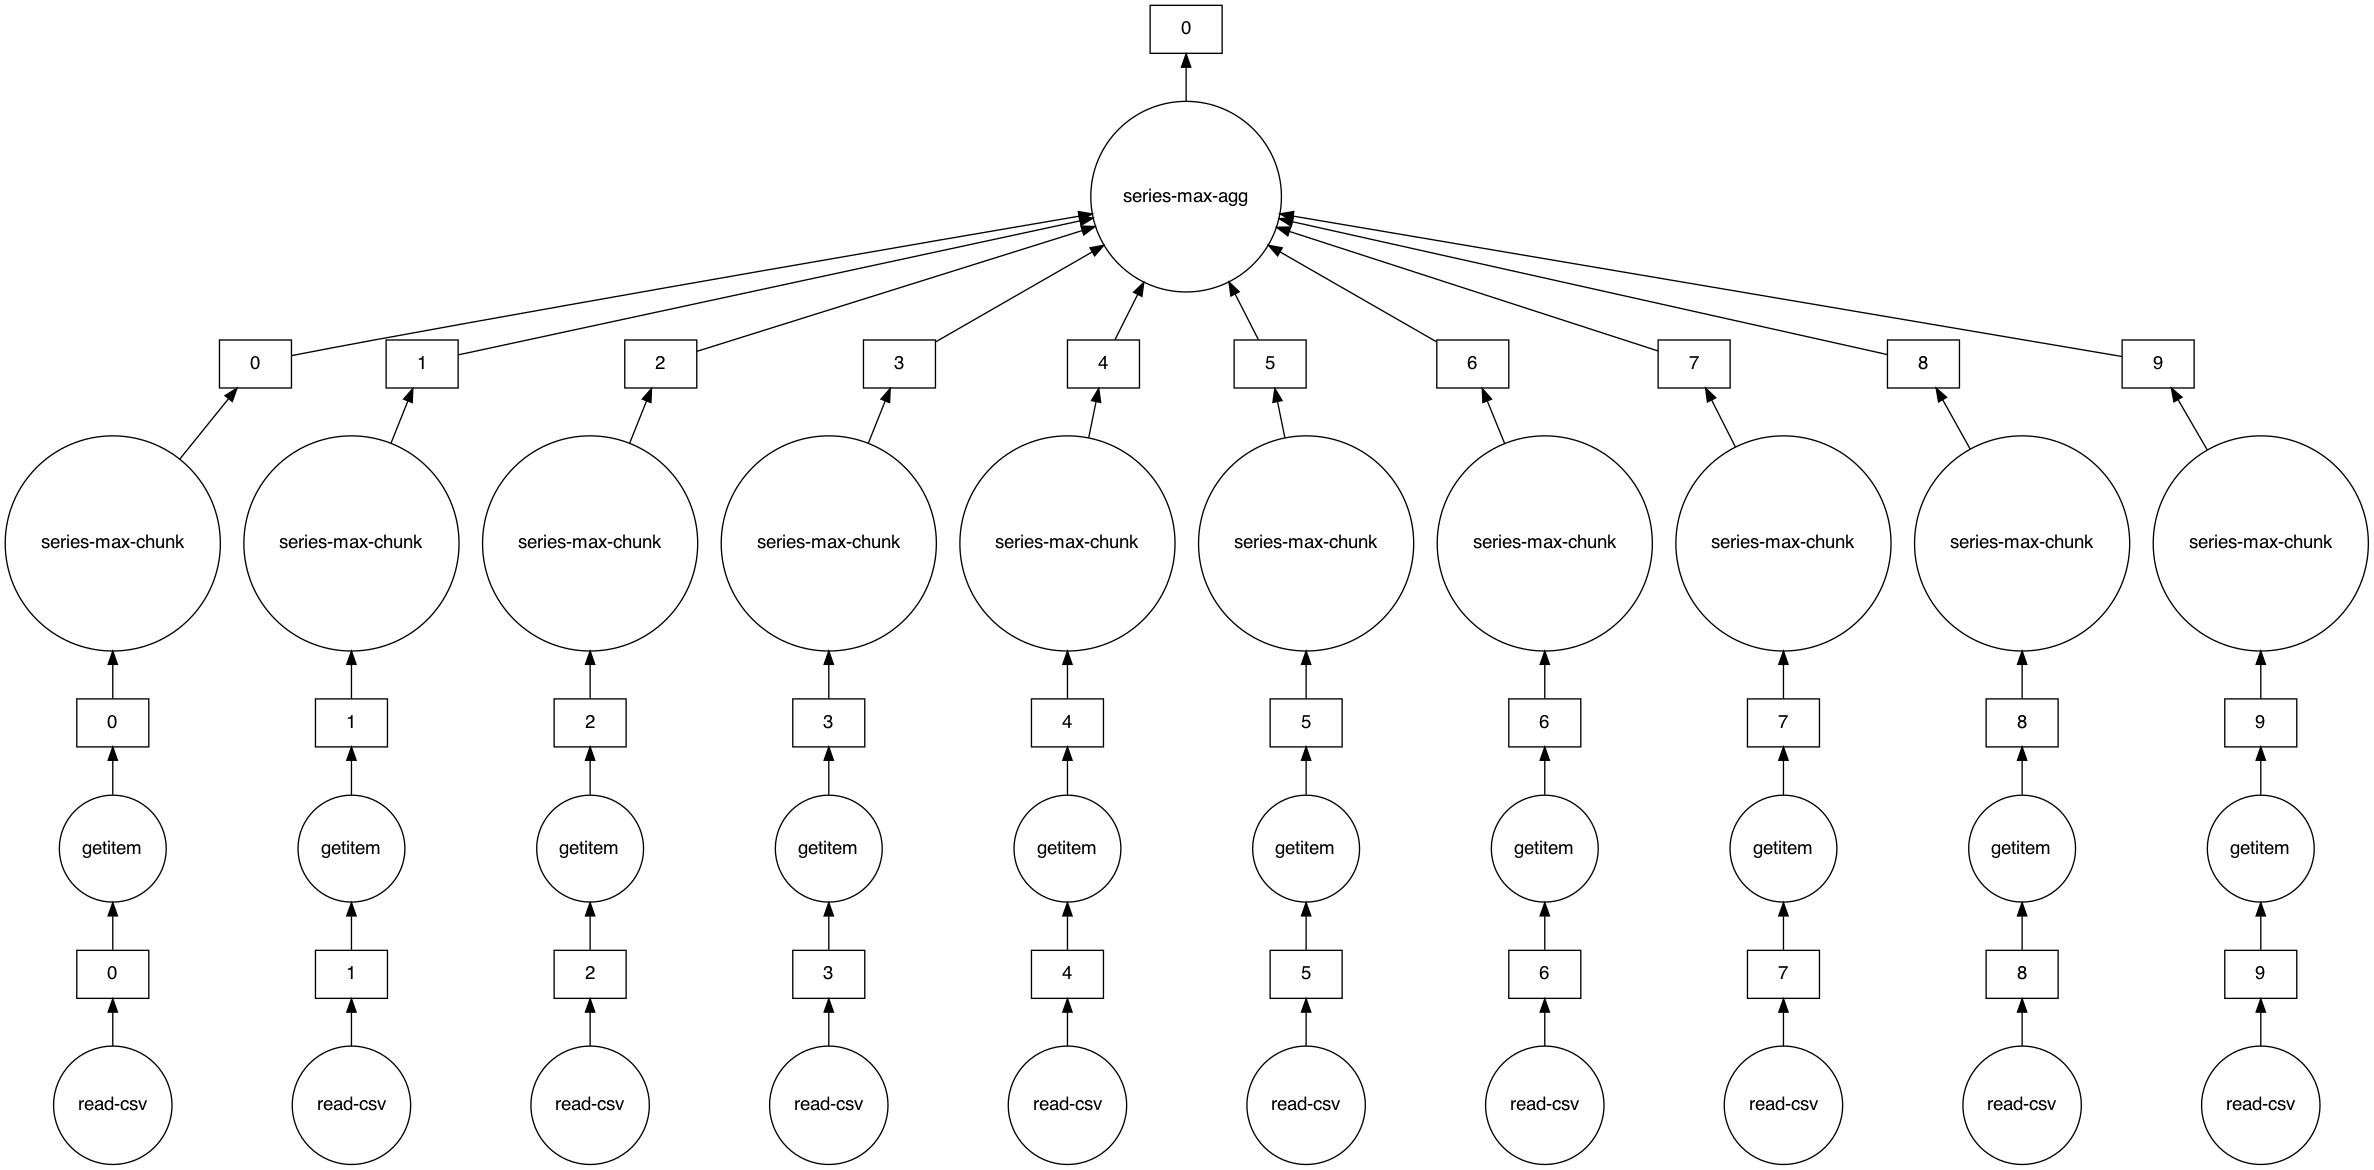

In [41]:
max_delay.visualize()

Some things to note:

1.  Up until this point everything is lazy. To evaluate the result for `max_delay`, call its `compute()` method:
2.  Dask will delete intermediate results (like the full pandas DataFrame for each file) as soon as possible.
    -  This lets us handle datasets that are larger than memory
    -  This means that repeated computations will have to load all of the data in each time 

In [42]:
%%time 
max_delay.compute()

CPU times: user 3.2 s, sys: 717 ms, total: 3.92 s
Wall time: 1.74 s


1435.0

## More Dask DataFrame computations

Let's see couple of examples on how the API for Dask DataFrames is the same than Pandas. If you are comfortable with Pandas, the following operations will look very familiar, except we will need to add the `compute()` to get the results wanted.

### Example 1: Total of non-cancelled flights taken

Notice that there is a column in our DataFrame called `"Cancelled"` that is a boolean. 

In [43]:
(~ddf["Cancelled"]).sum().compute()

2540961

### Example 2: Total of non-cancelled flights taken by airport

We should select the non-canceled flights, use the operation `groupby` on the `"Origin"` column and finally use `count` to get the detailed per airport.

In [44]:
ddf[~ddf["Cancelled"]].groupby("Origin")["Origin"].count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

### Exercise 1: What is the average departure delay from each airport?

Uncomment and run the cell below to see the solution.

In [46]:
# %load ./solutions/dataframe-ex-1.py
ddf.groupby("Origin")["DepDelay"].mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### Exercise 2: What day of the week has the worst average departure delay?
Uncomment and run the cell below to see the solution.

In [51]:
# %load ./solutions/dataframe-ex-2.py
#solution
ddf.groupby("DayOfWeek")["DepDelay"].mean().idxmax().compute()

5

## Working with Partitions
Dask DataFrames implements a large portion of the pandas API by simply performing pandas methods on its partitions (which are pandas objects). 

### Mapping Functions with `map_partitions`
However, sometimes you might want to manipulate your Dask DataFrame with a custom function. You can use the `map_partitions` method for this.

Imagine you find out that there was a 2-minute error in the `DepDelay` column.

Let's create a pandas `apply` function that will subtract 2 from every input:

In [52]:
def subtract_2(df):
    return df.apply(lambda x: x-2)

We can then map this function over all of our partitions:

In [53]:
ddf["Adjusted_DepDelay"] = ddf["DepDelay"].map_partitions(subtract_2)

In [54]:
ddf[["DepDelay", "Adjusted_DepDelay"]].head()

,DepDelay,Adjusted_DepDelay
0,41.0,39.0
1,7.0,5.0
2,6.0,4.0
3,2.0,0.0
4,9.0,7.0


## Performance tip: When to call .compute()

In the examples and exercises above, we sometimes perform the same operation more than once (e.g. `read_csv`). Dask DataFrames hashes the arguments, allowing duplicate computations to be shared, and only computed once. You can use `dask.compute()` to merge task graphs of multiple operations.

For example, let's compute the mean and standard deviation for departure delay of all non-canceled flights. Since Dask operations are lazy, those values aren't the final results until we `compute` them. They're just the recipe required to get the result.

If we compute them with two calls to compute, there is no sharing of intermediate computations.

In [55]:
non_cancelled = ddf[~ddf["Cancelled"]]
mean_delay = non_cancelled["DepDelay"].mean()
std_delay = non_cancelled["DepDelay"].std()

In [56]:
%%time
mean_delay_result = mean_delay.compute()
std_delay_result = std_delay.compute()

CPU times: user 7.38 s, sys: 1.24 s, total: 8.62 s
Wall time: 4.27 s


Now, let's see how long it takes if we try computing `mean_delay` and `std_delay` with a single `compute()` call.

In [57]:
import dask

In [58]:
%%time
mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 3.68 s, sys: 604 ms, total: 4.29 s
Wall time: 2.13 s


Using `dask.compute` takes roughly 1/2 the time. This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations (like `read_csv`) to only be done once instead of twice. In particular, using `dask.compute` only does the following once:

- The calls to `read_csv`
- The filter (`df[~df["Cancelled"]]`)
- The `"DepDelay"` column indexing
- Some of the necessary reductions (`sum`, `count`)

To see what the merged task graphs between multiple results look like (and what's shared), you can use the `dask.visualize` function:

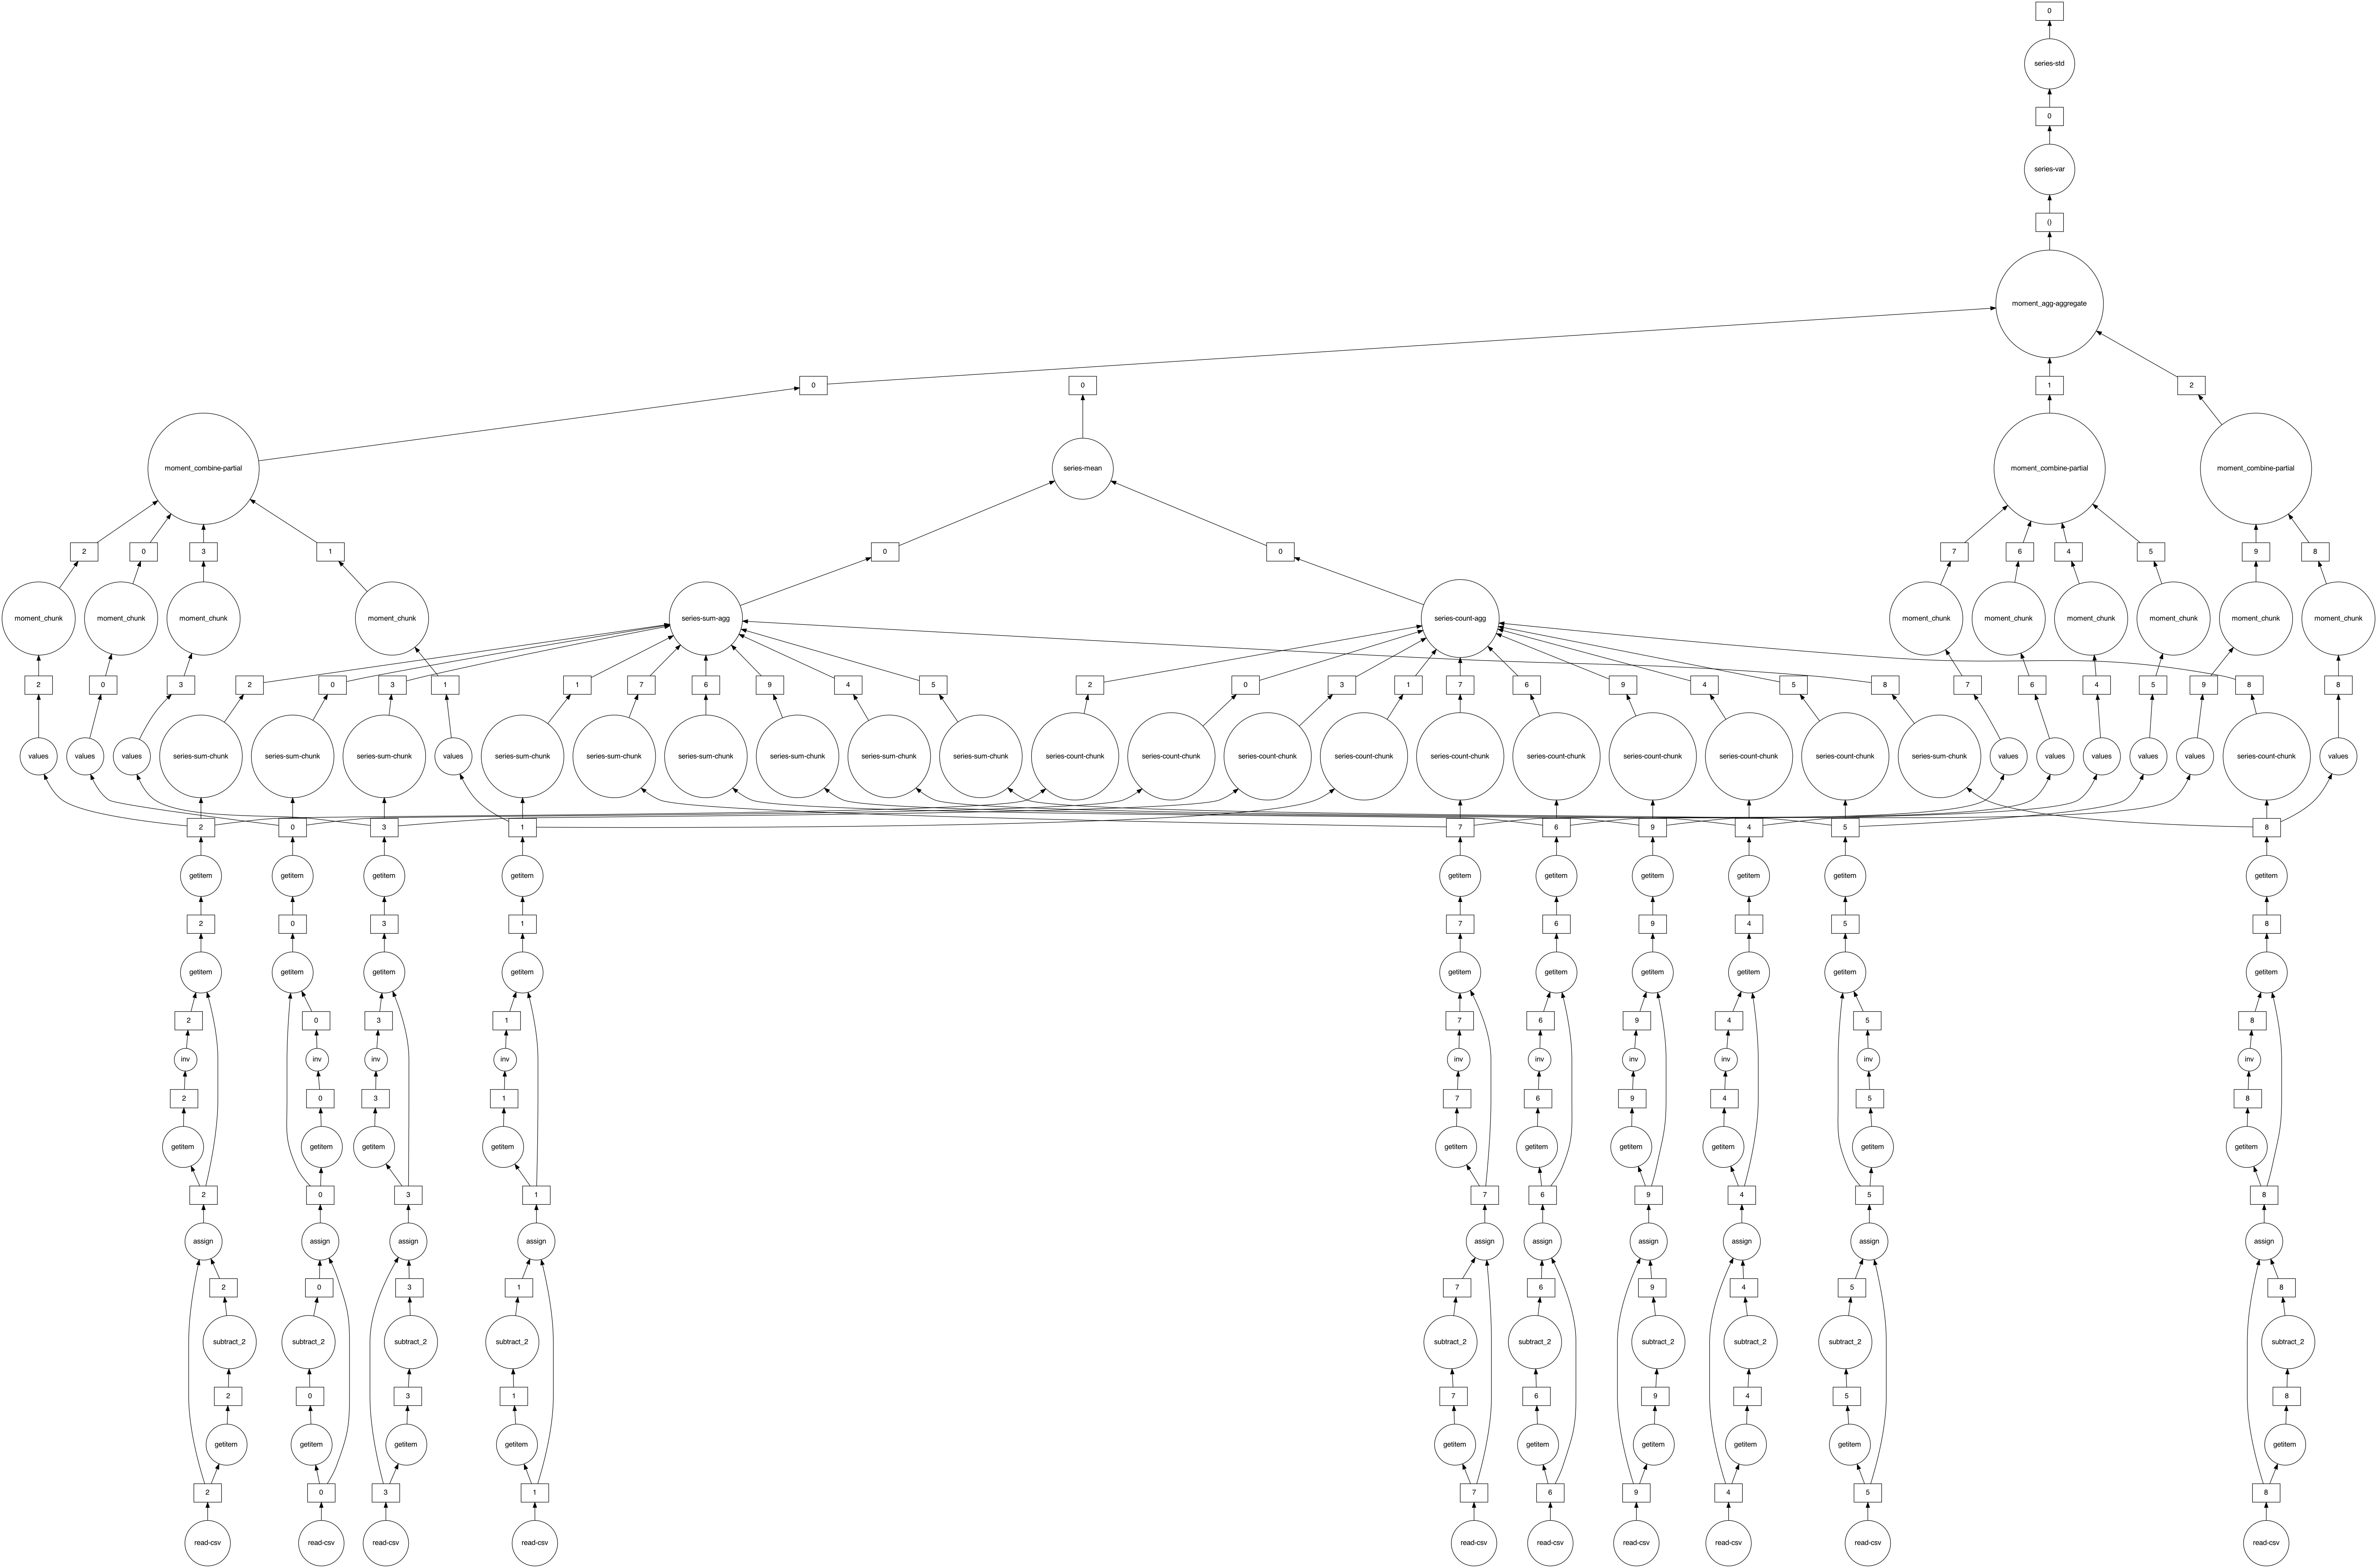

In [59]:
dask.visualize(mean_delay, std_delay)

# Extra resources

- Explore applying custom code to Dask DataFrames: [Dask Tutorial DataFrames](https://github.com/dask/dask-tutorial/blob/main/04_dataframe.ipynb)
- [Dask DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
- [Dask DataFrame examples](https://examples.dask.org/dataframe.html)